In [8]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for our plots
sns.set_style("whitegrid")

# set pandas parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("Libraries imported successfully.")

Libraries imported successfully.


```
Phase 1: Data Collection and Preparation
Task 1.1: Load the dataset from here.
Task 1.2: Load the dataset into a Pandas DataFrame.
Task 1.3: Inspect the dataset for missing values and handle them appropriately.
Task 1.4: Perform data cleaning to ensure the dataset is ready for analysis.


In [9]:
# data url as raw string
data_url = r"https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv"

#read data from url
data = pd.read_csv(data_url)
print("--- Data Loaded Successfully ---")
data.head()

--- Data Loaded Successfully ---


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [10]:
# inspection for missing values
print("\n--- Missing Value Counts (Training Data) ---")
print(data.isnull().sum())

# Check for duplicates
print(f"\n--- Duplicate Rows (Training Data) ---")
print(data.duplicated().sum())


--- Missing Value Counts (Training Data) ---
case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

--- Duplicate Rows (Training Data) ---
0


```
# Phase 2: Exploratory Data Analysis (EDA)
Task 2.1: Conduct exploratory data analysis to understand the distribution of features and the target variable .
Task 2.2: Visualize the relationships between features and the target variable using scatter plots, histograms, and box plots.
Task 2.3: Identify and handle outliers in the dataset.

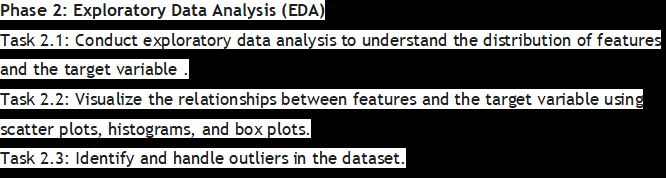
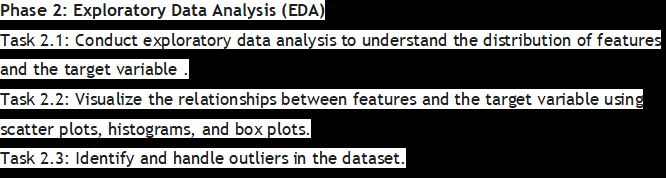

In [11]:
# since there are zero missing values, nothing to handle
print("--- Statistical Description of Numerical Data ---")
print(data.describe())
print(f"Skewness: \n{data.skew(numeric_only=True)}")

--- Statistical Description of Numerical Data ---
       no_of_employees   yr_of_estab  prevailing_wage
count     25480.000000  25480.000000     25480.000000
mean       5667.043210   1979.409929     74455.814592
std       22877.928848     42.366929     52815.942327
min         -26.000000   1800.000000         2.136700
25%        1022.000000   1976.000000     34015.480000
50%        2109.000000   1997.000000     70308.210000
75%        3504.000000   2005.000000    107735.512500
max      602069.000000   2016.000000    319210.270000
Skewness: 
no_of_employees    12.265260
yr_of_estab        -2.037301
prevailing_wage     0.755776
dtype: float64


## Key Insights:
```
no_of_employees has a large standard deviation(22,877), there is a big difference betweem its 75th percentile(3504) and it's max value(602,069). This indicates the data is highly right skewed and has very significant outliers.
Also, about 80 percent of all business looking to bring in foreign applicants are small businesses with less than 3500 customers

prevailing_wage has a large standard deviation(52,815), there is a big difference between its 75th percentile(107,735) and it's max value(319,210). This indicates the data is highly right skewed and has very significant outliers.

yr_of_estab has a standard deviation of 42 years, most business were established before 2005 with the latest being established 2016. That data also appears to be skewed towards the left

In [12]:
# visualize the distribution between the features and target varable
# Analyze the target variable 'case_status'
print("\n--- Target Variable Distribution (case_status) ---")
print(data['case_status'].value_counts())
print("\n--- Target Variable Proportions (case_status) ---")
print(data['case_status'].value_counts(normalize=True))


--- Target Variable Distribution (case_status) ---
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

--- Target Variable Proportions (case_status) ---
case_status
Certified    0.667896
Denied       0.332104
Name: proportion, dtype: float64


## Insight:
```
The dataset is imbalanced. About 66.78 percent of the cases were approved("Certified") while   33.21% were rejected ("Denied"). This is important to remeber for modelling later

## Visualize the relationships between features and the target variable using scatter plots, histograms, and box plots.
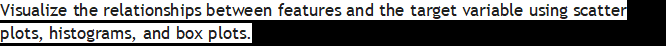

---Visual Distributions of Numerical Features---


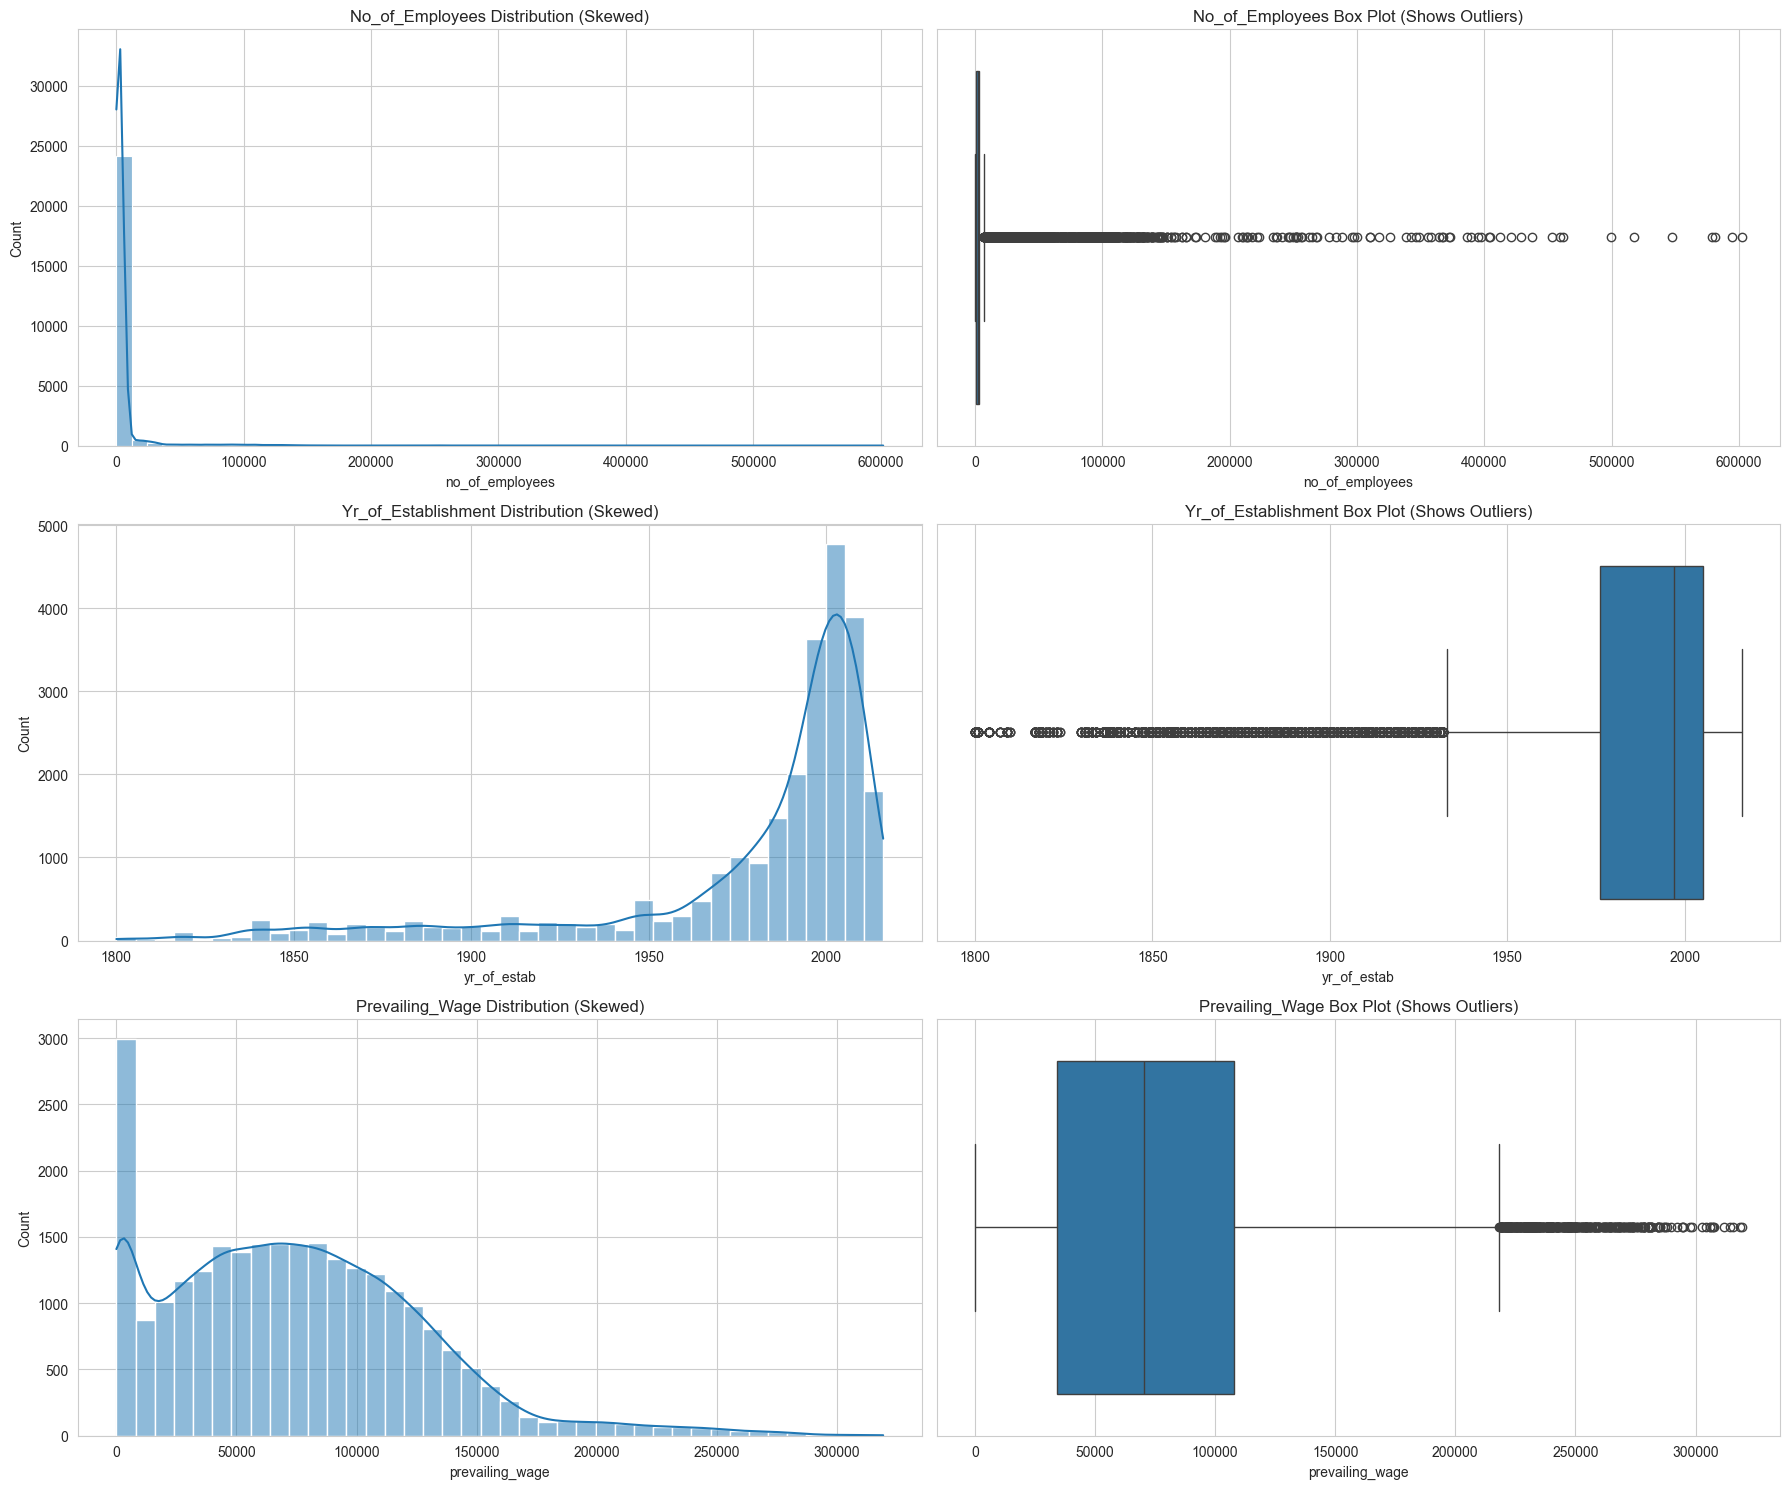

In [18]:
# Analyze and Visualize the Numerical Features using histograms and box plots
# Numerical Features: no_of_employees, yr_of_estab, prevailing_wage
print("---Visual Distributions of Numerical Features---")
# Set up a figure for 3x2 plots (Hist and Box for each)
plt.figure(figsize=(18, 15))

# Plot 1: No_of_Employees Histogram
plt.subplot(3, 2, 1)
sns.histplot(data['no_of_employees'], kde=True, bins=50)
plt.title('No_of_Employees Distribution (Skewed)')

# Plot 2: No_of_Employees Box Plot
plt.subplot(3, 2, 2)
sns.boxplot(x=data['no_of_employees'])
plt.title('No_of_Employees Box Plot (Shows Outliers)')

# Plot 3: Yr_of_Establishment Histogram
plt.subplot(3, 2, 3)
sns.histplot(data['yr_of_estab'], kde=True, bins=40)
plt.title('Yr_of_Establishment Distribution (Skewed)')

# Plot 4: Yr_of_Establishment Box Plot
plt.subplot(3, 2, 4)
sns.boxplot(x=data['yr_of_estab'])
plt.title('Yr_of_Establishment Box Plot (Shows Outliers)')

# Plot 5: prevailing_wage Histogram
plt.subplot(3, 2, 5)
sns.histplot(data['prevailing_wage'], kde=True, bins=40)
plt.title('Prevailing_Wage Distribution (Skewed)')

# Plot 6: Prevailing_Wage Box Plot
plt.subplot(3, 2, 6)
sns.boxplot(x=data['prevailing_wage'])
plt.title('Prevailing_Wage Box Plot (Shows Outliers)')

plt.tight_layout()
plt.show()

#### Insights

    The visualizations confirm our findings from describe(). All three features are heavily skewed and have significant outliers.

    Prevailing Wage is interesting: a large number of applicants have 0 prevailing wage, creating a large spike at 0.

    This skewness suggests that for modeling, we might need to apply a log transformation to these features to normalize their distributions.

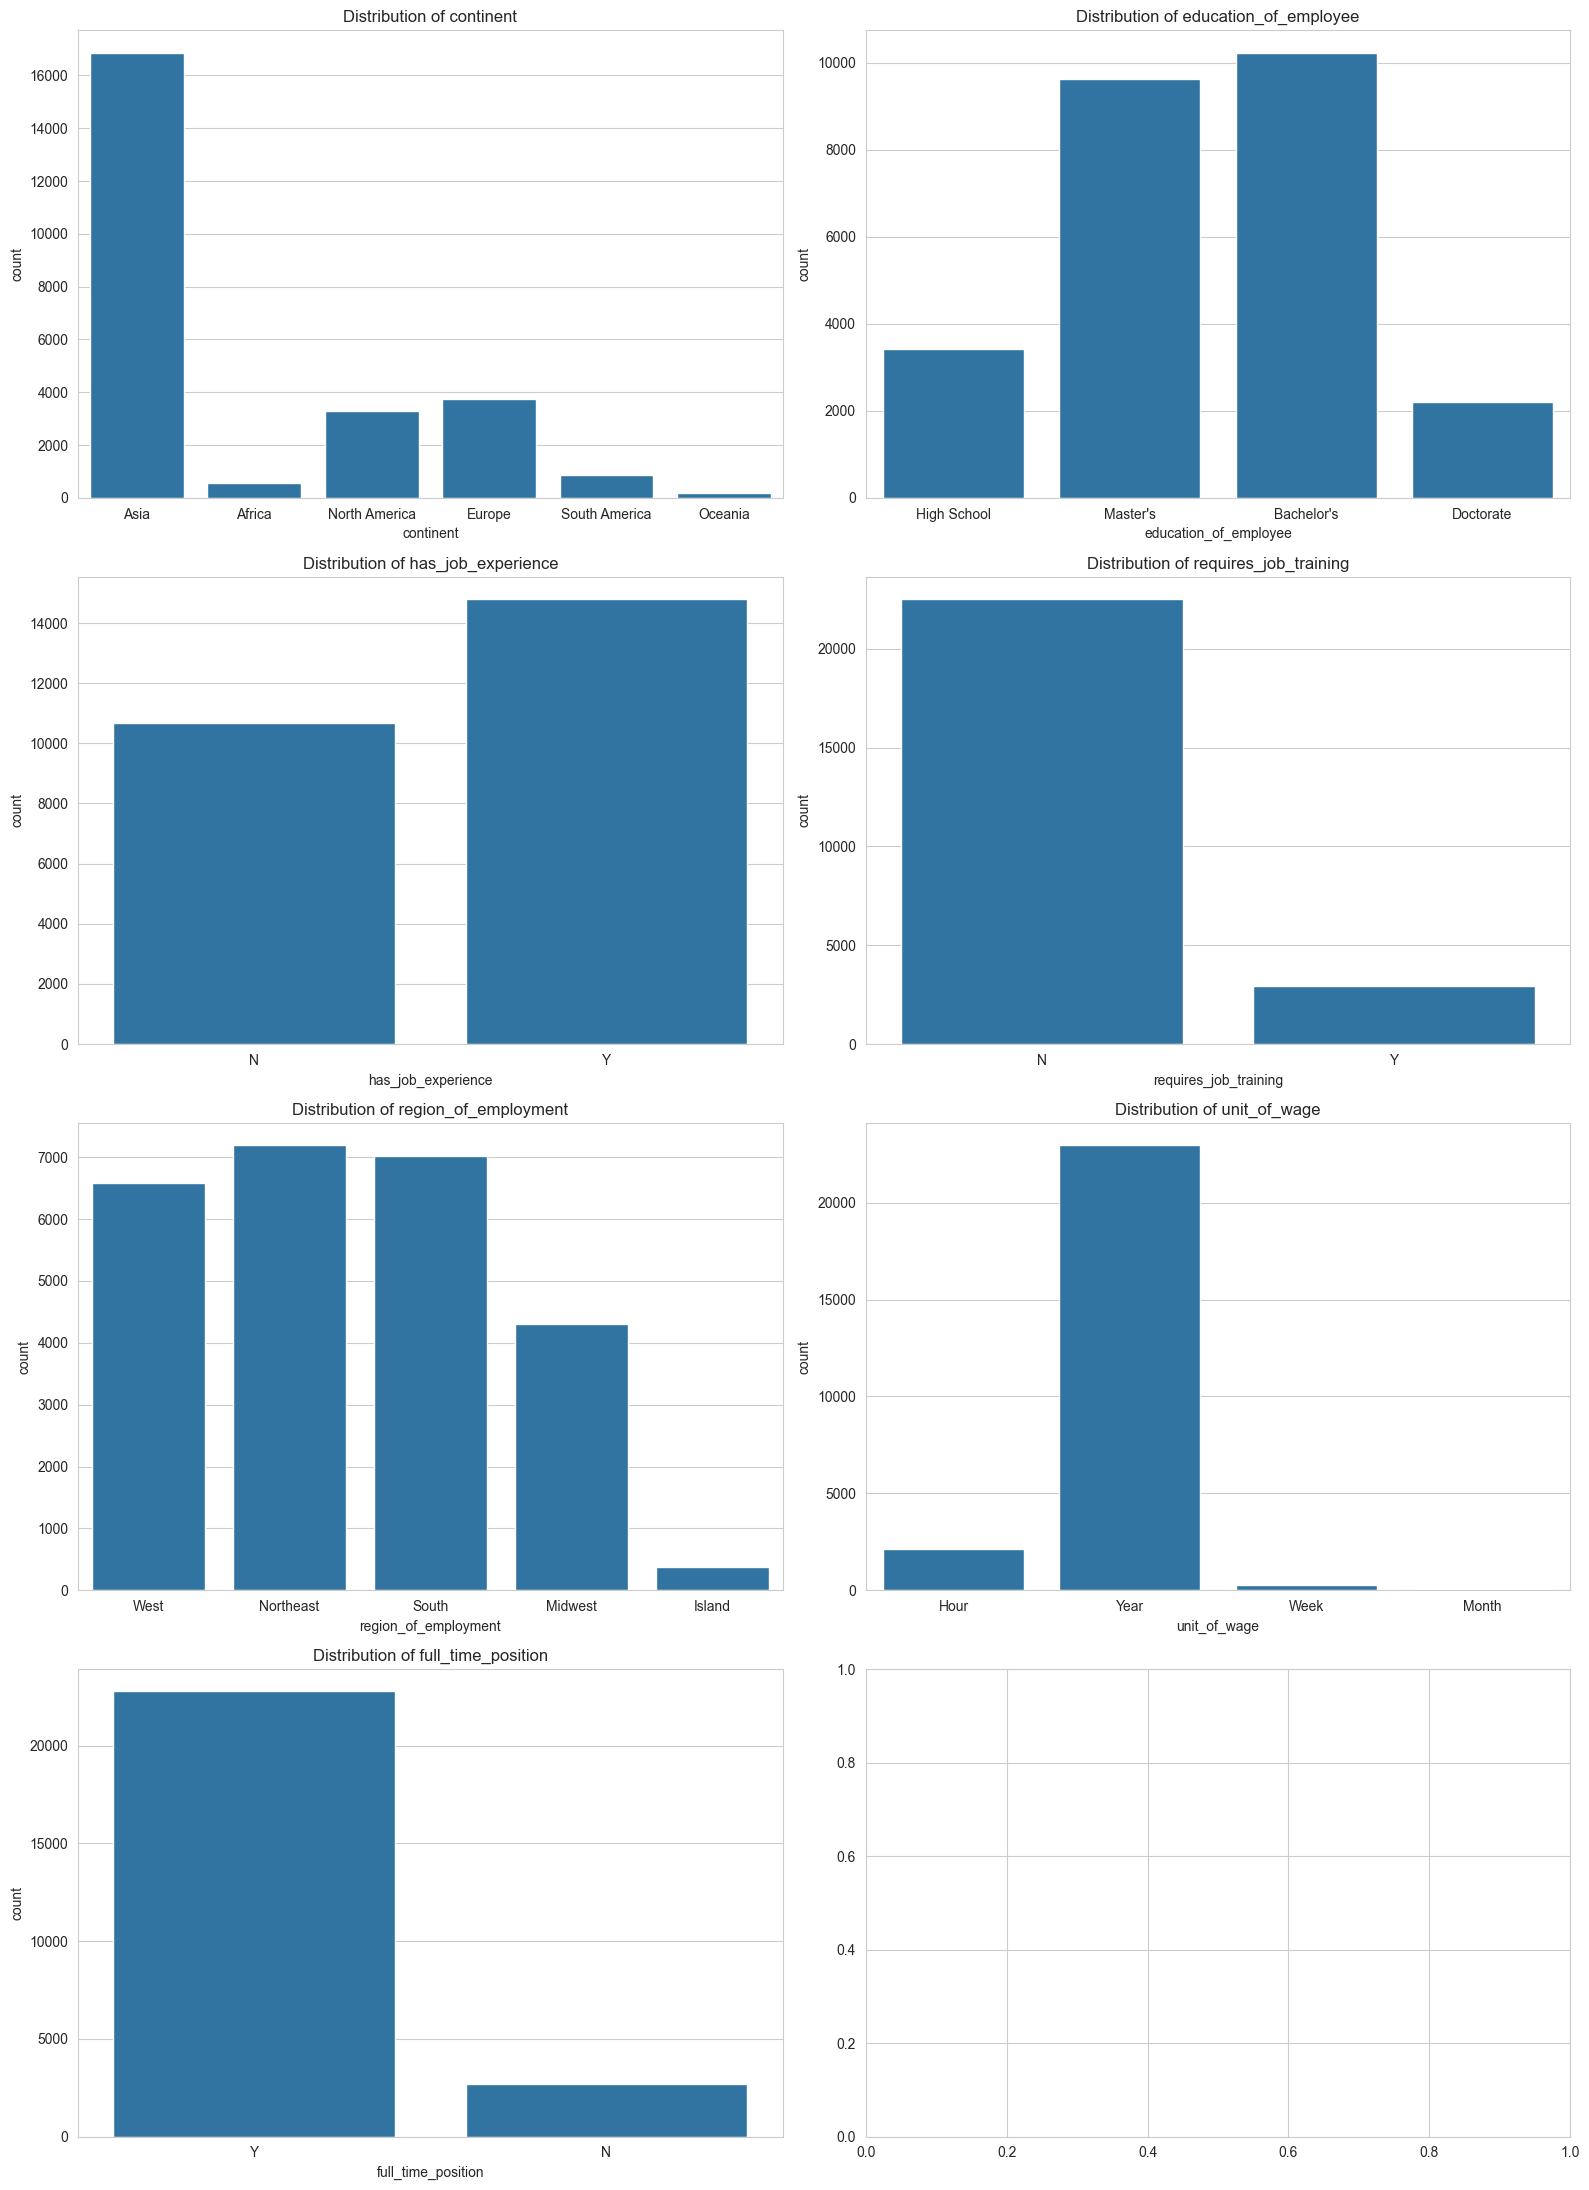

In [16]:
# Define all categorical and discrete features
categorical_features = ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']

# Set up the plot grid (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 22))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop and plot
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

#### Insights:
    continent: Majority of the Applicants are from Asia, then Europe, North America, South America, Africa and Oceania in that order

    education_of_employee: Majority of Applicants Have Either A Bachelor's or A Master's Degree, with fewer having just the High School Diploma or Doctorate

    has_job_experience: Job Experience is Split Fairly Evenly but with more apllicants having prior job experience

    requires_job_training: Majority of Applicants dont require Job Training

    region_of_employment:

    unit_of_wage: Most Applicants are to be paid per year

    full_time_position: Most Employers are offering full time positions


### Examine relationships between features and the target variable

### Categorical Features vs. case_status

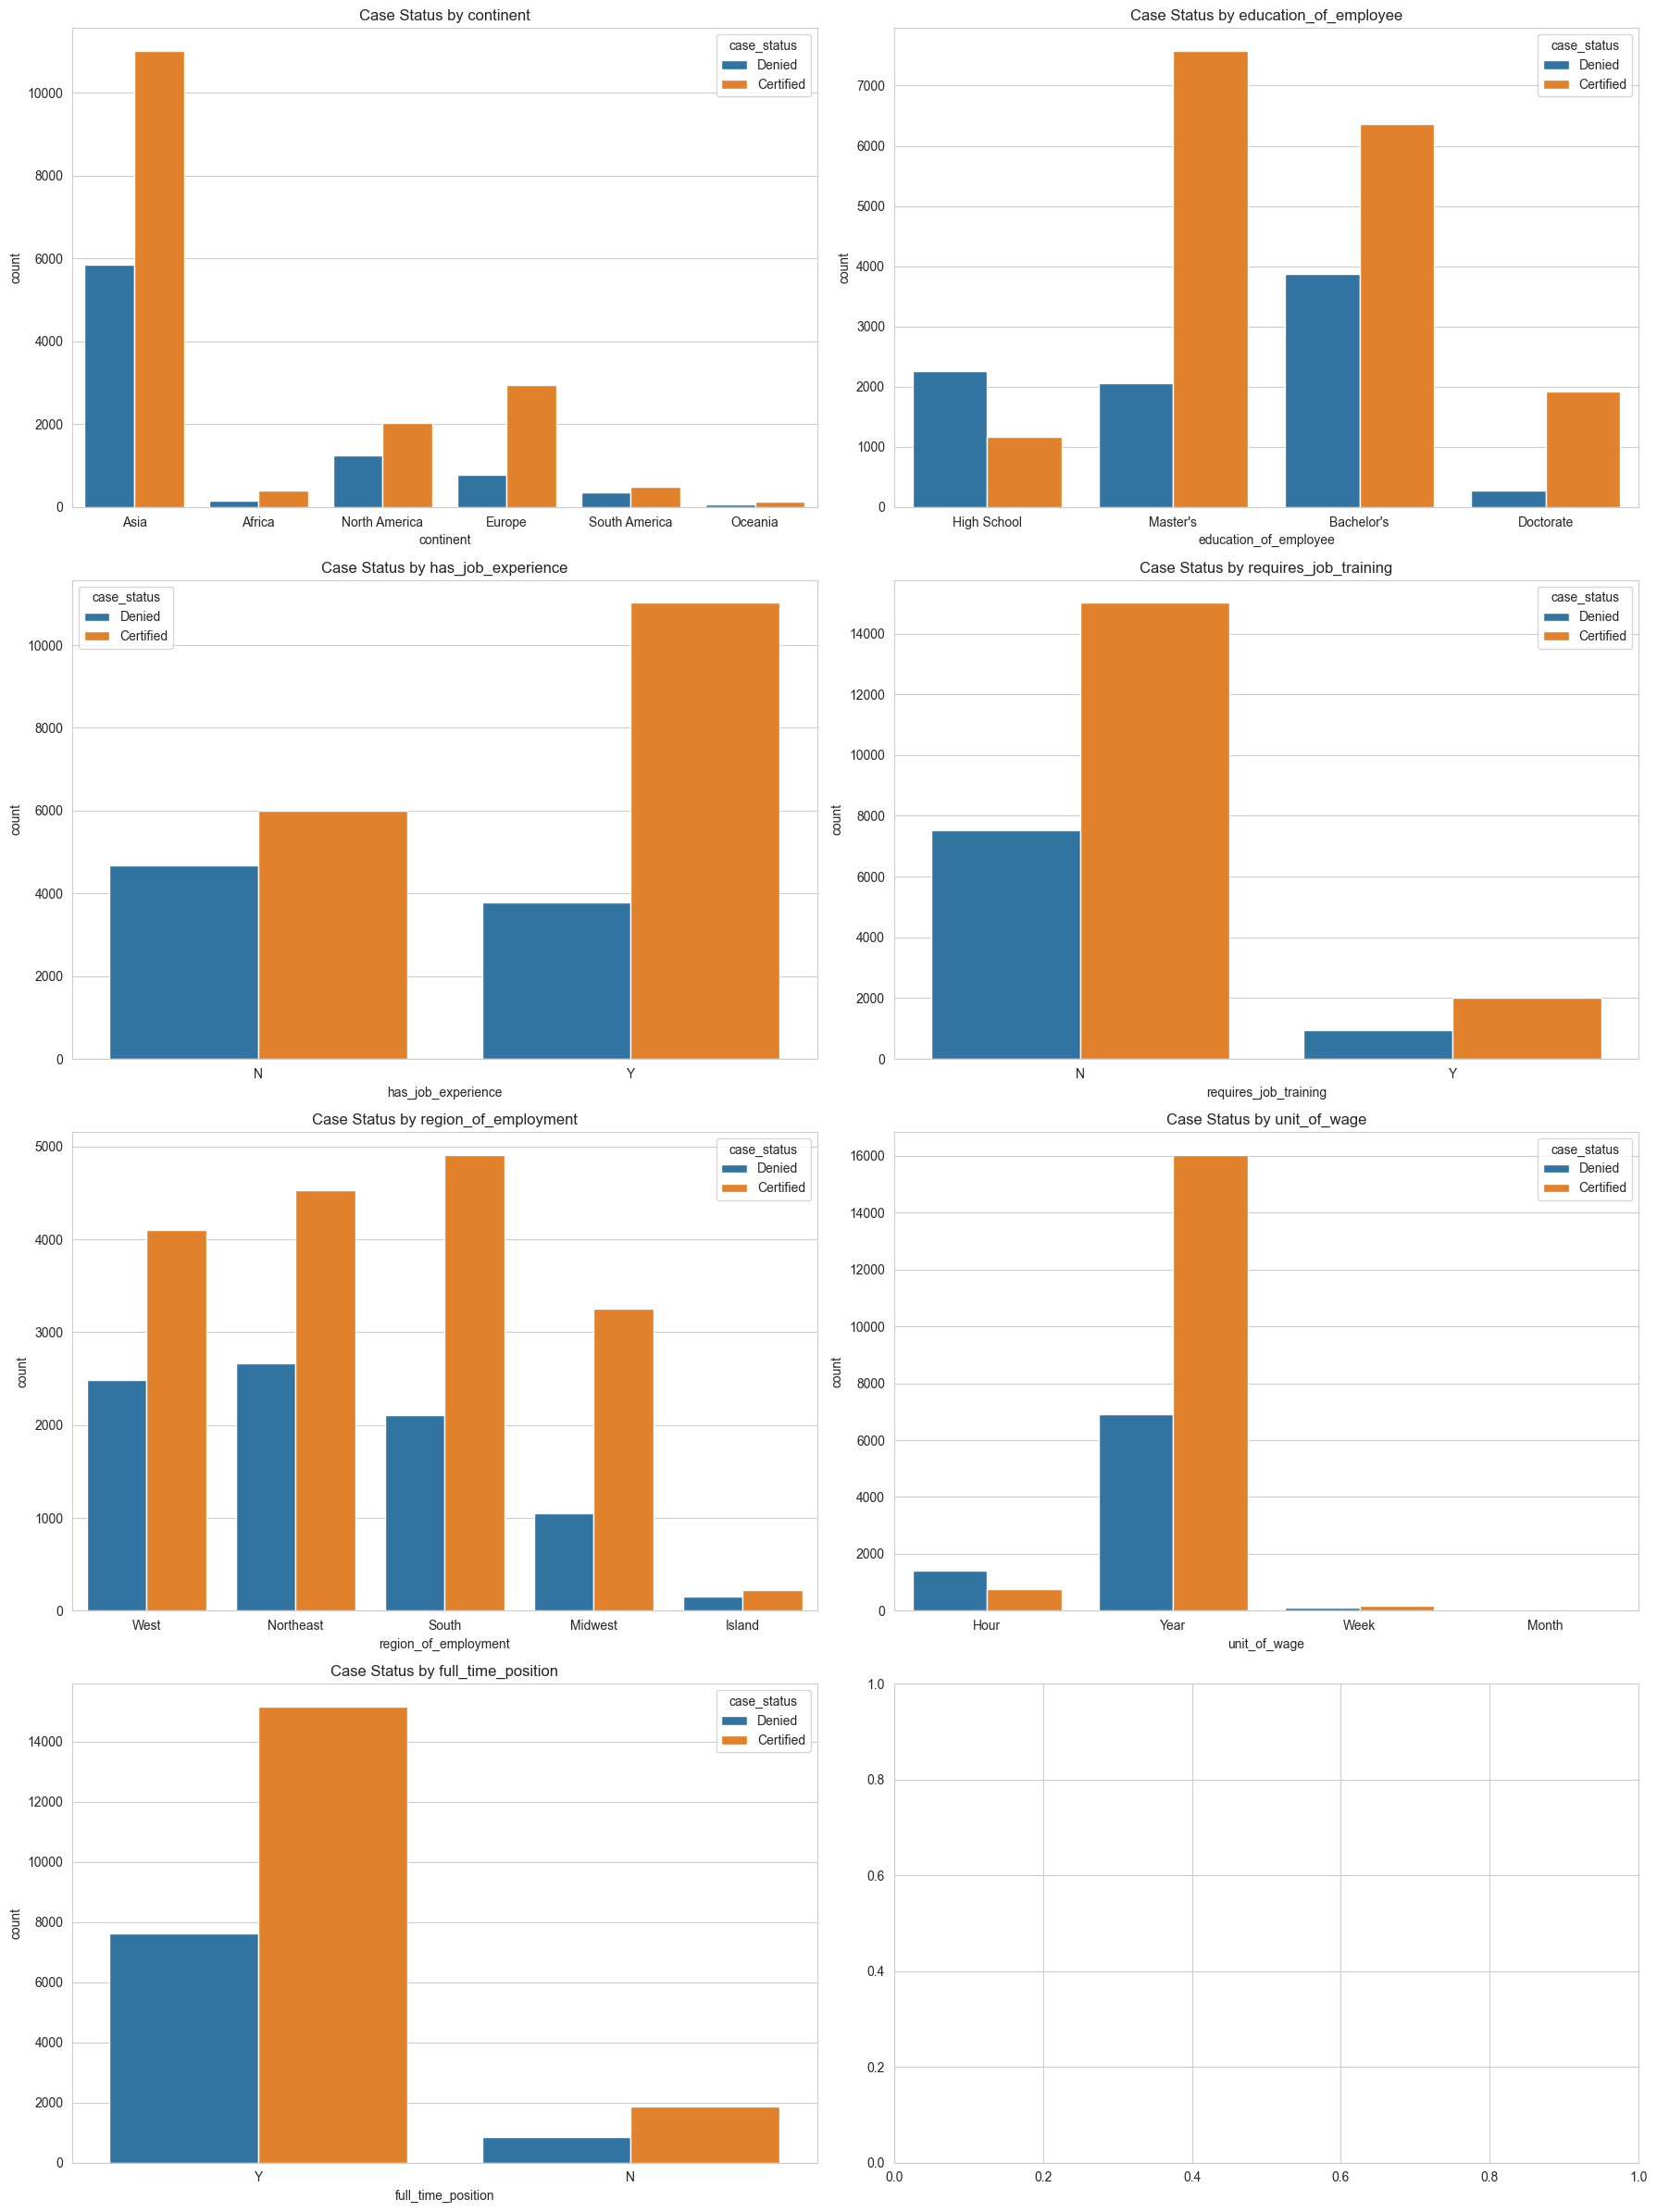

In [17]:
# We'll plot the same 8 features, but this time with 'Case_status' as the hue
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='case_status', data=data, ax=axes[i])
    axes[i].set_title(f'Case Status by {col}')

plt.tight_layout()
plt.show()

#### Insights

## Numerical Features vs Case Status

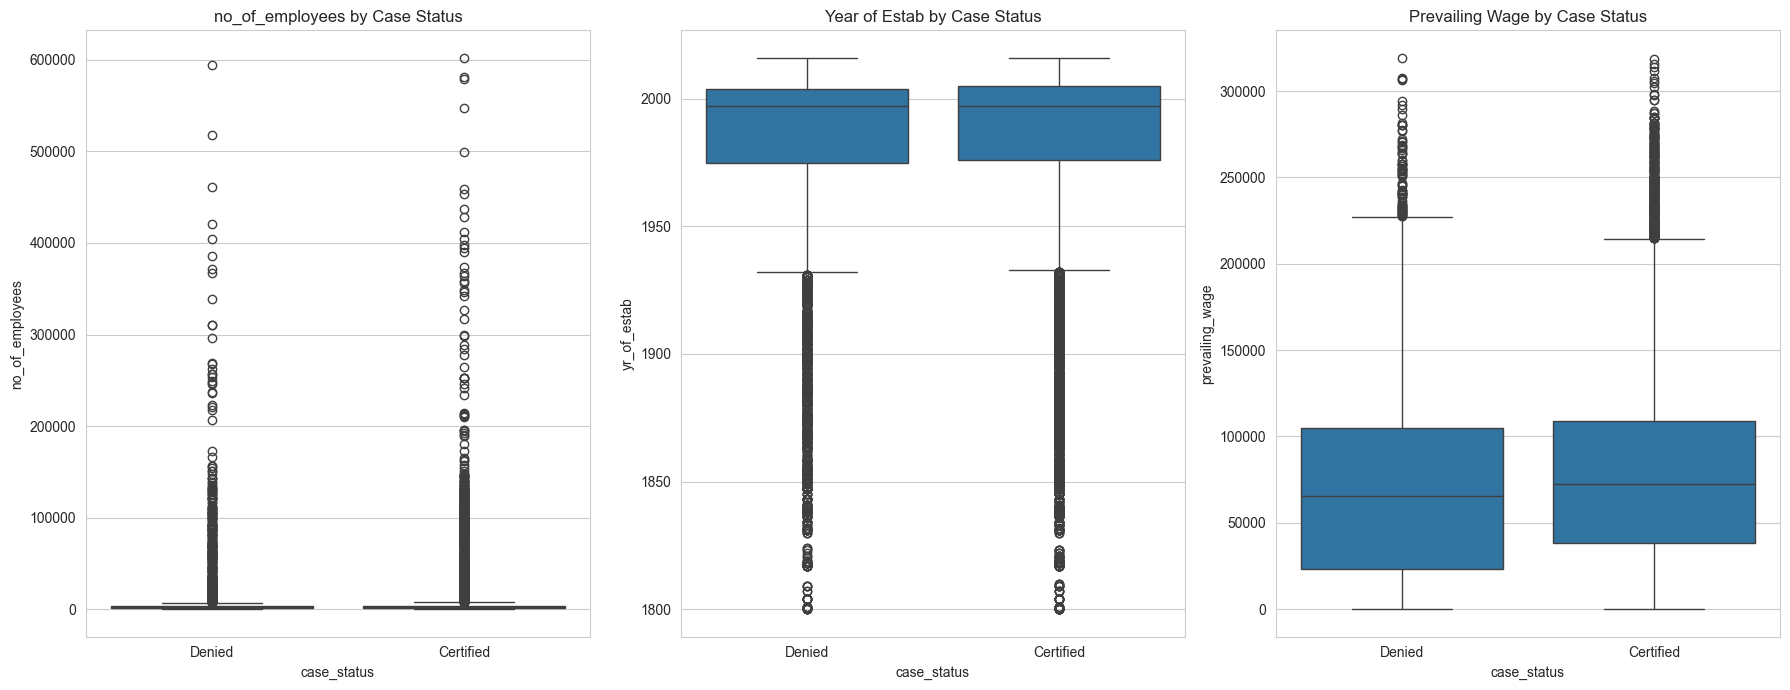

In [21]:
# Set up a figure for 3 plots
# Numerical Features: no_of_employees, yr_of_estab, prevailing_wage
plt.figure(figsize=(18, 7))

# Plot 1: no_of_employees vs. case_status
plt.subplot(1, 3, 1)
sns.boxplot(x='case_status', y='no_of_employees', data=data)
plt.title('no_of_employees by Case Status')

# Plot 2: yr_of_estab vs. case_status
plt.subplot(1, 3, 2)
sns.boxplot(x='case_status', y='yr_of_estab', data=data)
plt.title('Year of Estab by Case Status')

# Plot 3: prevailing_wage vs. case_status
plt.subplot(1, 3, 3)
sns.boxplot(x='case_status', y='prevailing_wage', data=data)
plt.title('Prevailing Wage by Case Status')

plt.tight_layout()
plt.show()

#### Insight

For all three continuous features, the median and interquartile range (the "box") are very similar for both 'Y' and 'N' groups.

This suggests that there is no simple, linear relationship (e.g., "higher prevailing wage = approval"). The relationship is more complex. The outliers are present in both groups.


#### Scatter Plots

C:\Users\ncc\PycharmProjects\GEN-AI\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


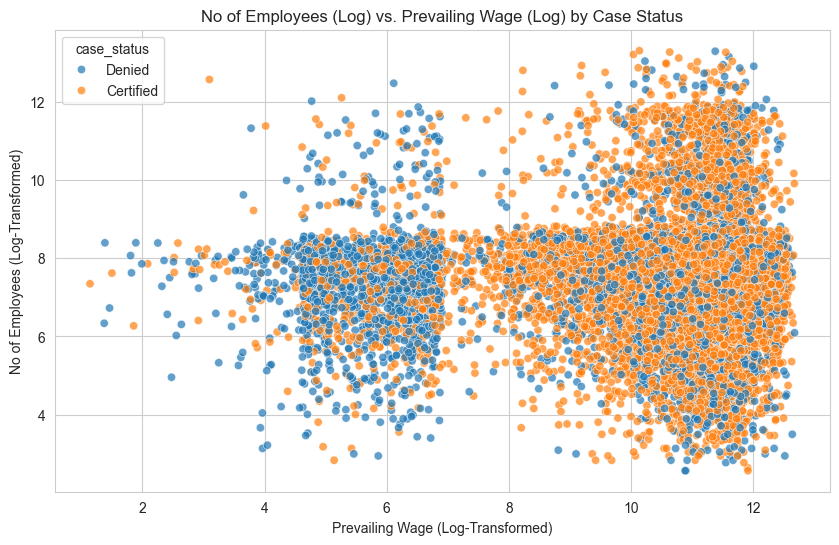

In [29]:
# Create a copy for this plot to avoid changing the original dataframe
# Numerical Features: no_of_employees, yr_of_estab, prevailing_wage
plot_df = data.copy()

# Apply log transform to fix skewness. Add 1 to avoid log(0)
# plot_df['prevailing_wage_log'] = np.log(plot_df['prevailing_wage'] + 1)
plot_df['prevailing_wage_log'] = np.log1p(plot_df['prevailing_wage'])
# plot_df['no_of_employees_log'] = np.log(plot_df['no_of_employees'] + 1)
plot_df['no_of_employees_log'] = np.log1p(plot_df['no_of_employees'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prevailing_wage_log', y='no_of_employees_log', hue='case_status', data=plot_df, alpha=0.7)
plt.title('No of Employees (Log) vs. Prevailing Wage (Log) by Case Status')
plt.xlabel('Prevailing Wage (Log-Transformed)')
plt.ylabel('No of Employees (Log-Transformed)')
plt.show()

#### Insights:
```
As the prevailing wage increases past a certain point, the frequency of approved applications increase regardless of the no_of_employees

This indicates that prevailing wage is a very strong factor

# Phase 3: Data Preprocessing
```
Task 3.1: Create new features that may help improve the model's performance.
Task 3.2: Encode categorical variables using one-hot or label encoding techniques.
Task 3.3: Normalize or standardize numerical features as needed.

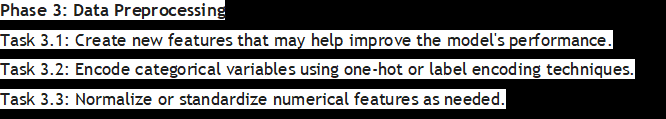

In [33]:
data

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,Certified


In [ ]:
# The first thing to do is to handle all of the skewed numercical data by applying log_transforms